# Cryptocurrency Price Forecasting - Keras LTSM

I will initially work with only the Bitcoin data and may in future generalise the code and use it for other cryptos if it works out for Bitcoin.

refs:
https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
http://philipperemy.github.io/keras-stateful-lstm/
http://adventuresinmachinelearning.com/keras-lstm-tutorial/

In [21]:
import pandas as pd
from pandas import DataFrame, concat, Series
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from math import sqrt
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import MinMaxScaler
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.cross_validation import  train_test_split
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 18, "axes.labelsize" : 12, 
            "xtick.labelsize" : 14, "ytick.labelsize" : 14 })

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('../input/all_currencies.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [4]:
# Extract the bitcoin data only
btc_df = df[df['Symbol'] == 'BTC']

# Resample to monthly frequency
#btc_df = btc_df.resample('M').mean()

btc_df.head()

,Symbol,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,,
2013-04-28,BTC,135.30,135.98,132.10,134.21,NaN,1.500520e+09
2013-04-29,BTC,134.44,147.49,134.00,144.54,NaN,1.491160e+09
2013-04-30,BTC,144.00,146.93,134.05,139.00,NaN,1.597780e+09
2013-05-01,BTC,139.00,139.89,107.72,116.99,NaN,1.542820e+09
2013-05-02,BTC,116.38,125.60,92.28,105.21,NaN,1.292190e+09


## Data Preparation

Before we can fit an LSTM model to the dataset, we must transform the data.

This section is broken down into three steps:

 - Transform the time series data so that it is stationary
 - Transform the time series for input into the NN
 - Scale the observations

In [6]:
# Convert to Close column to a series has index 4
series = btc_df.iloc[:,4]

### Transform Time Series to Stationary

If a timeseries is stationary, it implies the lack of broad trends (changes in mean and variance over time) in the data. This is important as a consideration in time series forecasting.

When building models to forecast time series data (like ARIMA) the data is often differenced (calculate sequentially xt−xt−1) until we get to a point where the series is stationary. Models account for oscillations but not for trends, and therefore, accounting for trends by differencing allows us to use the models that account for oscillations. Once the model has been constructed, we can account for trends separately, by adding the trends component-wise.

This can be done by using the diff() function in pandas, or we can get finer grained control and write our own function to do this, which is preferred for its flexibility in this case.

Below is a function called difference() that calculates a differenced series. Note that the first observation in the series is skipped as there is no prior observation with which to calculate a differenced value.

The inverse function is also defined in order to take forecasts made on the differenced series back into their original scale. 

In [7]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [8]:
# difference the data
raw_values = series.values
diff_values = difference(raw_values, 1)

### Transform Timeseries for input to NN

The LSTM model in Keras assumes the data is divided into input (X) and output (y) components. For a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output.

The shift() function in Pandas that moves all values in a series down by a specified number places. In this case a shift of 1 place is required to generate the input variables. The original time series will be used as the output variables.

The shift_timeseries() is defined to takes a NumPy array of the raw time series data and a lag, and create a shifted series to be used as input to the neural net.

In [9]:
# Get a series of shifted values
def shift_timeseries(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [ ]:
# Get the shifted input for the NN
shifted_values = convert_timeseries_to_supervised(diff_values, 1).values

Lets define the test set as the past year and the training set as all the rest of the past data that we have (from early 2013).

In [11]:
# split data into train and test-sets
train, test = shifted_values[0:-365], shifted_values[-365:]

### Scale timeseries

Like other neural networks, LSTMs expect data to be within the scale of the activation function used by the network. The default activation function for LSTMs is the hyperbolic tangent (tanh), which outputs values between -1 and 1. This is the preferred range for the time series data.

The dataset is transformed to the range [-1, 1] using the MinMaxScaler class. Like other scikit-learn transform classes, it requires data provided in a matrix format with rows and columns. Therefore, we must reshape our NumPy arrays before transforming.

In [12]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

Note: The data needs to be scaled AFTER the training/test split because scaling requires the calculation of min/max, which in real life we do not have for future observations at the time of forecasting.  Therefore, calculation of scaling statistics has to be conducted on training data and must then be applied to the test data. Otherwise future information at the time of forecasting will invalidate the forecasting metrics.

In [13]:
# scale the data
scaler, train_scaled, test_scaled = scale(train, test)

## LSTM Model Development

A Long Short-Term Memory network (LSTM) network is a kind of recurrent neural network (RNN). A RNN is a neural network that attempts to model time or sequence dependent behaviour. The problem with standard RNNs, constructed from regular neural network nodes, is that as we try to model dependencies between sequence values that are separated by a significant number of other values, we experience the vanishing/exploding gradient problem.

This is because small gradients or weights (values less than 1) are multiplied many times over through the multiple time steps, and the gradients shrink asymptotically to zero. This means the weights of those earlier layers won’t be changed significantly and therefore the network won’t learn long-term dependencies.

One solution is to consider adding the updates instead of multiplying them, and this is exactly what the LSTM does.

LSTM networks are a way of solving this problem. It has LSTM cell blocks in place of the standard NN layers and can learn and remember over long sequences. It does not rely on a pre-specified window lagged observation as input. 

In order to use this type of model in Keras, we need to set the "stateful" argument to True.

Lets define the fit_lstm() function train a LSTM model. Initially we will create a simple network with just one LSTM layer.

A rolling-forecast scenario will be used, in which each time step of the test dataset will be walked one at a time. A model will be used to make a forecast for the time step, then the actual expected value from the test set will be taken and made available to the model for the forecast on the next time step.

In [41]:
train_scaled.shape

(1433, 2)

In [40]:
train[:, 0:-1].shape

(1433, 1)

In [43]:
train[:, -1].shape

(1433,)

In [37]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

The batch size limits the number of samples to be shown to the network before a weight update can be performed. In this case we want to make one-step predictions, as is usual with timeseries, so we will set it to 1.

We will not tune the network parameters in this tutorial; instead we will use the following configuration, found with a little trial and error:

    Batch Size: 1
    Epochs: 3000
    Neurons: 4
    
The optimizer that will be used is the Adam optimizer – an effective “all round” optimizer with adaptive stepping. 

## LSTM Forecast

In [15]:
# one-step forecast method
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [28]:
# fit the model
batch_size = 1
epochs = 2
#epochs = 3000
neurons = 2
test_days = -365

lstm_model = fit_lstm(train_scaled, batch_size, epochs, neurons)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
trian_predict = lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    #print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Epoch 1/1
1433/1433 [==============================] - 4s 3ms/step - loss: 0.0135
Epoch 1/1
1433/1433 [==============================] - 3s 2ms/step - loss: 0.0134


In [30]:
x

Day=1, Predicted=1043.115206, Expected=1080.500000
Day=2, Predicted=1056.697877, Expected=1102.170000
Day=3, Predicted=1084.123567, Expected=1143.810000
Day=4, Predicted=1130.123611, Expected=1133.250000
Day=5, Predicted=1121.796533, Expected=1124.780000
Day=6, Predicted=1115.711861, Expected=1182.680000
Day=7, Predicted=1176.626032, Expected=1176.900000
Day=8, Predicted=1172.803225, Expected=1175.950000
Day=9, Predicted=1173.305375, Expected=1187.870000
Day=10, Predicted=1186.398654, Expected=1187.130000
Day=11, Predicted=1186.530022, Expected=1205.010000
Day=12, Predicted=1205.143486, Expected=1200.370000
Day=13, Predicted=1201.052338, Expected=1169.280000
Day=14, Predicted=1169.949415, Expected=1167.540000
Day=15, Predicted=1168.113933, Expected=1172.520000
Day=16, Predicted=1173.185732, Expected=1182.940000
Day=17, Predicted=1183.859805, Expected=1193.910000
Day=18, Predicted=1195.159042, Expected=1211.670000
Day=19, Predicted=1213.276050, Expected=1210.290000
Day=20, Predicted=121

Day=266, Predicted=15718.344184, Expected=13831.800000
Day=267, Predicted=13741.343125, Expected=14699.200000
Day=268, Predicted=14669.056119, Expected=13925.800000
Day=269, Predicted=13833.678653, Expected=14026.600000
Day=270, Predicted=13980.616880, Expected=16099.800000
Day=271, Predicted=16099.492666, Expected=15838.500000
Day=272, Predicted=15832.485422, Expected=14606.500000
Day=273, Predicted=14534.745061, Expected=14656.200000
Day=274, Predicted=14637.817604, Expected=12952.200000
Day=275, Predicted=12868.381332, Expected=14156.400000
Day=276, Predicted=14120.226221, Expected=13657.200000
Day=277, Predicted=13613.647814, Expected=14982.100000
Day=278, Predicted=14967.531592, Expected=15201.000000
Day=279, Predicted=15195.316628, Expected=15599.200000
Day=280, Predicted=15595.071019, Expected=17429.500000
Day=281, Predicted=17429.192666, Expected=17527.000000
Day=282, Predicted=17527.752771, Expected=16477.600000
Day=283, Predicted=16428.532134, Expected=15170.100000
Day=284, P

In [31]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[test_days:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 521.071


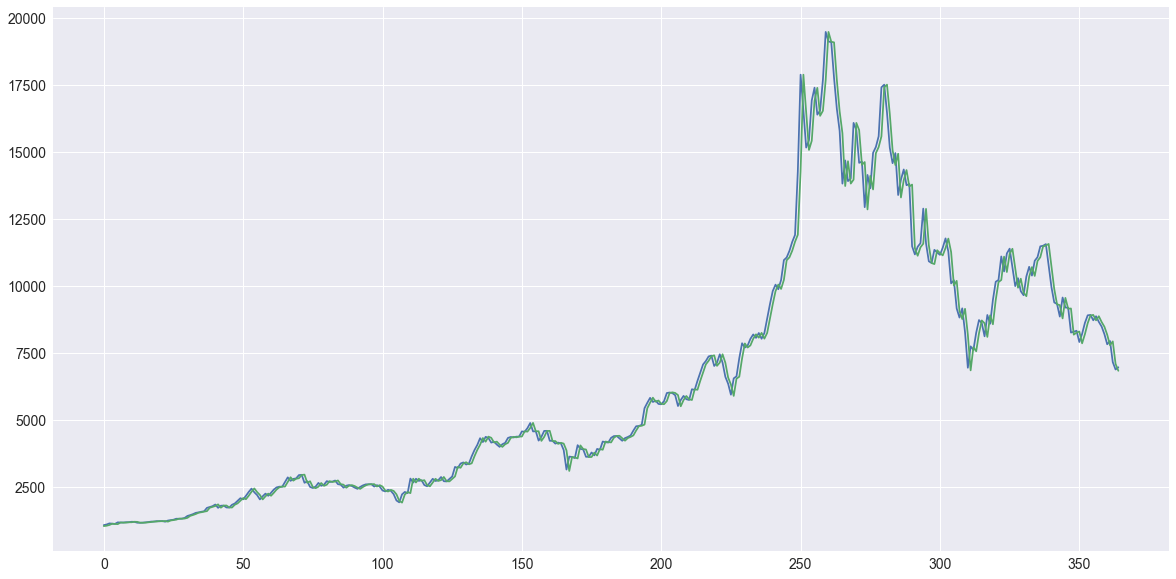

In [32]:
# plot of observed vs predicted
plt.plot(raw_values[test_days:])
plt.plot(predictions)
plt.show()

So the one-step predictions are fairly accurate. Lets try this out with monthly predictions.

In [33]:
# fit the model
batch_size = 12
epochs = 2
#epochs = 3000
neurons = 2
test_days = -365

lstm_model = fit_lstm(train_scaled, batch_size, epochs, neurons)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
trian_predict = lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    #print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

ValueError: In a stateful network, you should only pass inputs with a number of samples that can be divided by the batch size. Found: 1433 samples

In [ ]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[test_days:], predictions))
print('Test RMSE: %.3f' % rmse)

In [ ]:
# plot of observed vs predicted
plt.plot(raw_values[test_days:])
plt.plot(predictions)
plt.show()